## Dataset

In [0]:
!unzip -q ad-2d.zip

In [0]:
!unzip -q cn-2d.zip

In [0]:
!mkdir training && mkdir validation

In [0]:
!mkdir training/ad && mkdir validation/ad

In [0]:
!mkdir training/cn && mkdir validation/cn

In [0]:
!mkdir ad && mkdir cn

In [0]:
import os
import shutil

In [0]:
ad_main_folder = 'ad-2d'
cn_main_folder = 'cn-2d'

for ad_folder in os.listdir(ad_main_folder):
  images_name_path = f'{ad_main_folder}/{ad_folder}'
  images = os.listdir(images_name_path)
  
  for image_path in images:
    image_url = f'{images_name_path}/{image_path}'
    shutil.move(image_url, 'ad')
    
for cn_folder in os.listdir(cn_main_folder):
  images_name_path = f'{cn_main_folder}/{cn_folder}'
  images = os.listdir(images_name_path)
  
  for image_path in images:
    image_url = f'{images_name_path}/{image_path}'
    shutil.move(image_url, 'cn')

In [0]:
class_size = len(os.listdir('ad'))
validation_size = 0.20
validation_class_size = int(class_size * 0.20)

In [16]:
class_size, validation_class_size

(39753, 7950)

In [0]:
training_ad_folder_name = "training/ad"
training_cn_folder_name = "training/cn"

validation_ad_folder_name = "validation/ad"
validation_cn_folder_name = "validation/cn"

ad_folder = os.listdir("ad")
cn_folder = os.listdir("cn")

for image_name in ad_folder[:validation_class_size]:
  image_url = f'ad/{image_name}'
  shutil.move(image_url, validation_ad_folder_name)
  
for image_name in ad_folder[validation_class_size:]:
  image_url = f'ad/{image_name}'
  shutil.move(image_url, training_ad_folder_name)
  
for image_name in cn_folder[:validation_class_size]:
  image_url = f'cn/{image_name}'
  shutil.move(image_url, validation_cn_folder_name)
  
for image_name in cn_folder[validation_class_size:]:
  image_url = f'cn/{image_name}'
  shutil.move(image_url, training_cn_folder_name)

## TensorFlow

In [0]:
!pip install -q tensorflow-gpu==2.0.0-beta1

In [0]:
import tensorflow as tf

In [3]:
tf.__version__

'2.0.0-beta1'

In [0]:
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras import layers
from tensorflow.python.keras.utils.data_utils import Sequence

from tensorflow.keras.utils import to_categorical

from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, LearningRateScheduler

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import PIL
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import itertools

## Generators

In [0]:
batch_size = 128
img_size = 128
input_img_size = (128, 128, 1)
num_classes = 2

In [19]:
train_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True,
    fill_mode="nearest").flow_from_directory(
    "training",
    target_size=(img_size, img_size),
    color_mode="grayscale",
	  shuffle=True,
    batch_size=batch_size)

val_generator = ImageDataGenerator(
    preprocessing_function=preprocess_input).flow_from_directory(
    "validation",
    target_size=(img_size, img_size),
    color_mode="grayscale",
	  shuffle=False,
    batch_size=batch_size)

Found 63646 images belonging to 2 classes.
Found 15900 images belonging to 2 classes.


In [0]:
training_folder_size = 63646
validation_folder_size = 15900

In [0]:
train_steps = training_folder_size // batch_size
val_steps = validation_folder_size // batch_size

In [22]:
train_steps, val_steps

(497, 124)

## Model

In [0]:
def create_model():
  mobile_model = MobileNetV2(
       weights=None,
       input_shape=input_img_size,
       alpha=1.5,
       include_top=False)
  
  for layer in mobile_model.layers:
    layer.trainable = True
  
  model = mobile_model.layers[-3].output

  model = layers.GlobalAveragePooling2D()(model)
  
  model = layers.Dense(num_classes, activation="softmax", kernel_initializer='uniform')(model)
  
  model = Model(inputs=mobile_model.input, outputs=model)
  
  return model

In [0]:
learning_rate = 3e-4
epochs = 100

In [0]:
def polynomial_decay(epoch):
  power = 1.0
  
  alpha = learning_rate * (1 - (epoch / float(epochs))) ** power
  
  return alpha

In [26]:
weights_name = "epoch={epoch:02d}|accuracy={acc:.4f}|val_accuracy={val_acc:.4f}.h5"

checkpoint = ModelCheckpoint(weights_name, monitor="val_acc", verbose=1, save_best_only=True,
                                 save_weights_only=True, mode="max", period=1)

lr_decay = LearningRateScheduler(polynomial_decay)

optimizer = SGD(lr=learning_rate, momentum=0.9)

W0815 20:36:52.238962 139943530751872 callbacks.py:859] `period` argument is deprecated. Please use `save_freq` to specify the frequency in number of samples seen.


In [0]:
model = None
model = create_model()

In [0]:
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

In [0]:
trained_model = model.fit_generator(train_generator,
                        epochs=epochs,
                        steps_per_epoch=train_steps,
                        callbacks=[checkpoint, lr_decay],
                        validation_data=val_generator,
                        validation_steps=val_steps,
                        verbose=1)

Epoch 1/100


W0718 19:49:57.154111 139832459503488 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


496/497 [============================>.] - ETA: 0s - loss: 0.6799 - acc: 0.5747
Epoch 00001: val_acc improved from -inf to 0.50088, saving model to epoch=01|accuracy=0.5746|val_accuracy=0.5009.h5
497/497 [==============================] - 457s 920ms/step - loss: 0.6799 - acc: 0.5746 - val_loss: 0.6947 - val_acc: 0.5009
Epoch 2/100
496/497 [============================>.] - ETA: 0s - loss: 0.6680 - acc: 0.5966
Epoch 00002: val_acc did not improve from 0.50088
497/497 [==============================] - 417s 838ms/step - loss: 0.6680 - acc: 0.5964 - val_loss: 0.6988 - val_acc: 0.5009
Epoch 3/100
496/497 [============================>.] - ETA: 0s - loss: 0.6645 - acc: 0.6026
Epoch 00003: val_acc did not improve from 0.50088
497/497 [==============================] - 417s 839ms/step - loss: 0.6644 - acc: 0.6026 - val_loss: 0.7026 - val_acc: 0.5009
Epoch 4/100
496/497 [============================>.] - ETA: 0s - loss: 0.6581 - acc: 0.6115
Epoch 00004: val_acc did not improve from 0.50088
497

## Results

In [0]:
def plot_validation_training(metric, trained_model):
  validation_metric = trained_model.history[f'val_{metric}']
  training_metric = trained_model.history[metric]
  epochs = range(len(training_metric))
  plt.plot(epochs, training_metric, 'b', label=f'Training {metric}')
  plt.plot(epochs, validation_metric, 'r', label=f'Validation {metric}')
  plt.ylim(bottom=0)
  plt.xlabel('Epochs ', fontsize=16)
  plt.ylabel(metric, fontsize=16)
  loc = 'upper right' if metric == "loss" else 'lower right'
  plt.legend(loc=loc)
  plt.title(f'Training and validation {metric}', fontsize = 20)
  plt.show()

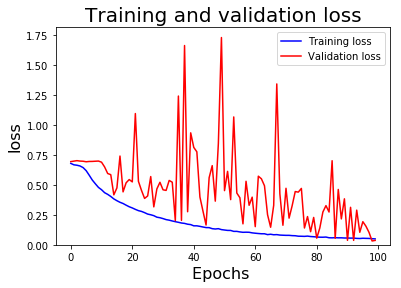

In [0]:
plot_validation_training("loss", trained_model)

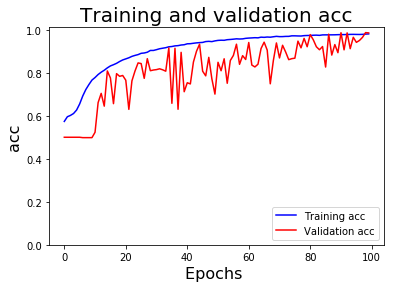

In [0]:
plot_validation_training("acc", trained_model)

## Confusion Matrix

In [0]:
model.load_weights("epoch=99_accuracy=0.9813_val_accuracy=0.9883.h5")

In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [0]:
val_generator.reset()

In [32]:
val_generator.class_indices

{'ad': 0, 'cn': 1}

In [0]:
def test_model(generator):
  predicted_classes = model.predict_generator(generator, verbose=1)
  max_class_predicted = np.argmax(predicted_classes, axis=1)
  
  classes_names = ["ad", "cn"]
  
  labels = val_generator.classes
  
  cm = confusion_matrix(labels, max_class_predicted, labels=range(num_classes))
  plot_confusion_matrix(cm, classes_names)
  
  sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
  print(f'sensitivity: {sensitivity}')

  specificity = cm[1, 1] / (cm[1, 1] + cm[1, 0])
  print(f'specifity: {specificity}')
  
  incorrect_labels = np.where(max_class_predicted != labels)[0]
  
  return max_class_predicted, incorrect_labels

125/125 [==============================] - 20s 157ms/step
sensitivity: 0.9925786163522012
specifity: 0.9934591194968554


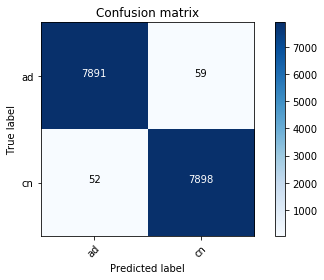

In [34]:
val_class_predicted, val_incorrect_labels = test_model(val_generator)

In [0]:
from sklearn.metrics import classification_report

In [0]:
labels = val_generator.classes
classes_names = ["ad", "cn"]

In [38]:
report = classification_report(val_class_predicted, labels, target_names=classes_names)
print(report)

              precision    recall  f1-score   support

          ad       0.99      0.99      0.99      7943
          cn       0.99      0.99      0.99      7957

    accuracy                           0.99     15900
   macro avg       0.99      0.99      0.99     15900
weighted avg       0.99      0.99      0.99     15900



## Activation Maps

In [0]:
def get_activation_map(image_path, image_class_vector):        
        image_loaded = PIL.Image.open(image_path)
        image_loaded = image_loaded.resize((img_size, img_size))
        image_loaded = np.asarray(image_loaded)
      
        if len(image_loaded.shape) < 3:
          image_loaded = np.stack([image_loaded.copy()] * 3, axis=2)
        
        preprocessed_image = preprocess_input(image_loaded)
        preprocessed_image = np.expand_dims(preprocessed_image, axis=0)
        
        image_class = np.argmax(image_class_vector)

        class_weights = model.layers[-1].get_weights()[0]
        final_conv_layer = model.layers[-3]
        
        get_output = tf.keras.backend.function([model.layers[0].input], 
                                               [final_conv_layer.output, model.layers[-1].output])
        
        [conv_outputs, predictions] = get_output(preprocessed_image)
        conv_outputs = conv_outputs[0, :, :, :]

        cam = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2])

        for index, weight in enumerate(class_weights[:, image_class]):
          cam += weight * conv_outputs[:, :, index]
        
        class_predicted = np.argmax(predictions[0])
        predictions = f'Class predicted: {class_predicted} | Real class: {image_class}'
        
        cam /= np.max(cam)
        cam = cv2.resize(cam, (img_size, img_size))
        heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
        heatmap[np.where(cam < 0.2)] = 0
        
        img = heatmap * 0.5 + image_loaded
        cv2.imwrite("heatmap.jpg", img)
        
        heatmap = mpimg.imread("heatmap.jpg")
        
        scaled_image = (((img - img.min()) * 255) / (img.max() - img.min())).astype(np.uint8)
        
        fig, ax = plt.subplots(1, 2, figsize=(10, 10))
        ax[0].imshow(image_loaded)

        ax[0].set_title('Original image')

        ax[1].imshow(heatmap)
        ax[1].set_title(predictions)

In [0]:
cn_path = "validation/cn"
ad_path = "validation/ad"

In [0]:
cn_val_images_paths = os.listdir(cn_path)
ad_val_images_paths = os.listdir(ad_path)

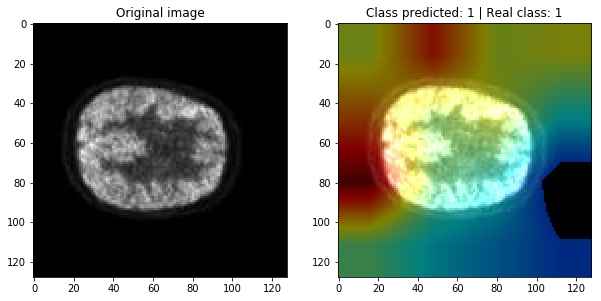

In [52]:
get_activation_map(f'{cn_path}/{cn_val_images_paths[100]}', [0, 1])

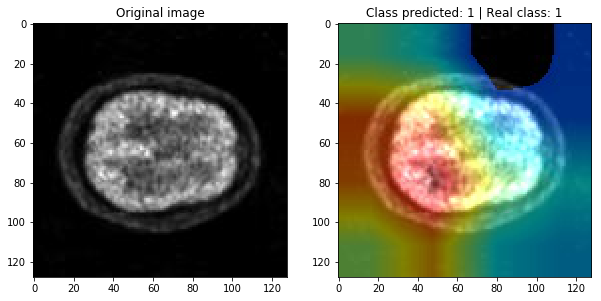

In [51]:
get_activation_map(f'{cn_path}/{cn_val_images_paths[25]}', [0, 1])

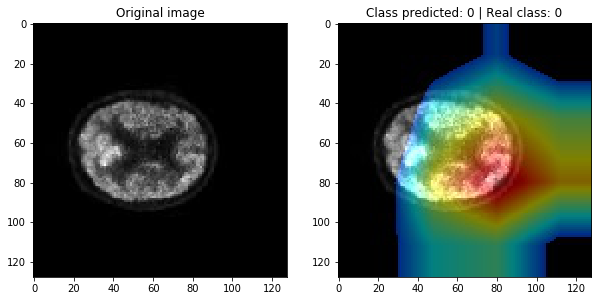

In [47]:
get_activation_map(f'{ad_path}/{ad_val_images_paths[0]}', [1, 0])

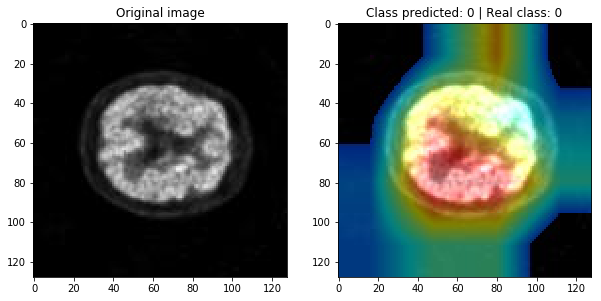

In [50]:
get_activation_map(f'{ad_path}/{ad_val_images_paths[1]}', [1, 0])

## Save model

In [0]:
model_json = model.to_json()
with open("ad.json", "w") as json_file:
    json_file.write(model_json)

In [0]:
model.save('ad.h5')